In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
import glob
import pandas as pd
import json
from astropy.stats import sigma_clip
from scipy.stats import iqr
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly
plotly.offline.init_notebook_mode()

plt.style.use('seaborn-white')
mpl.rcParams.update({'font.size': 16})

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Investigating the effect of S/N on Measurement Difference and Lowercut

In [2]:
# Make dictionary of cluster S/N tables

cluster_snr = glob.glob("data/ew_known/equiv_widths/*snr.txt")
snr_dict = {}
for cluster in cluster_snr:
    df = pd.read_csv(cluster, delim_whitespace = True)
    key = cluster.split("/")[-1].split("_")[0]
    snr_dict[key] = df

print(snr_dict['col110'])
snr_dict['ngc2506'].index[snr_dict['ngc2506']['Star'] == 3265].tolist()
snr_dict['ngc2506'].loc[1]['S/N']

   Star  S/N
0  1134  113
1  2119   92
2  2129  118
3  2223   92
4  3122  105
5  3144   78
6  3244  104
7  4260   77
8  5125   83


52

### Measurement Difference

[-0.022579113355360426, 3.4697321569161494]
R-Squared:  0.172047898913


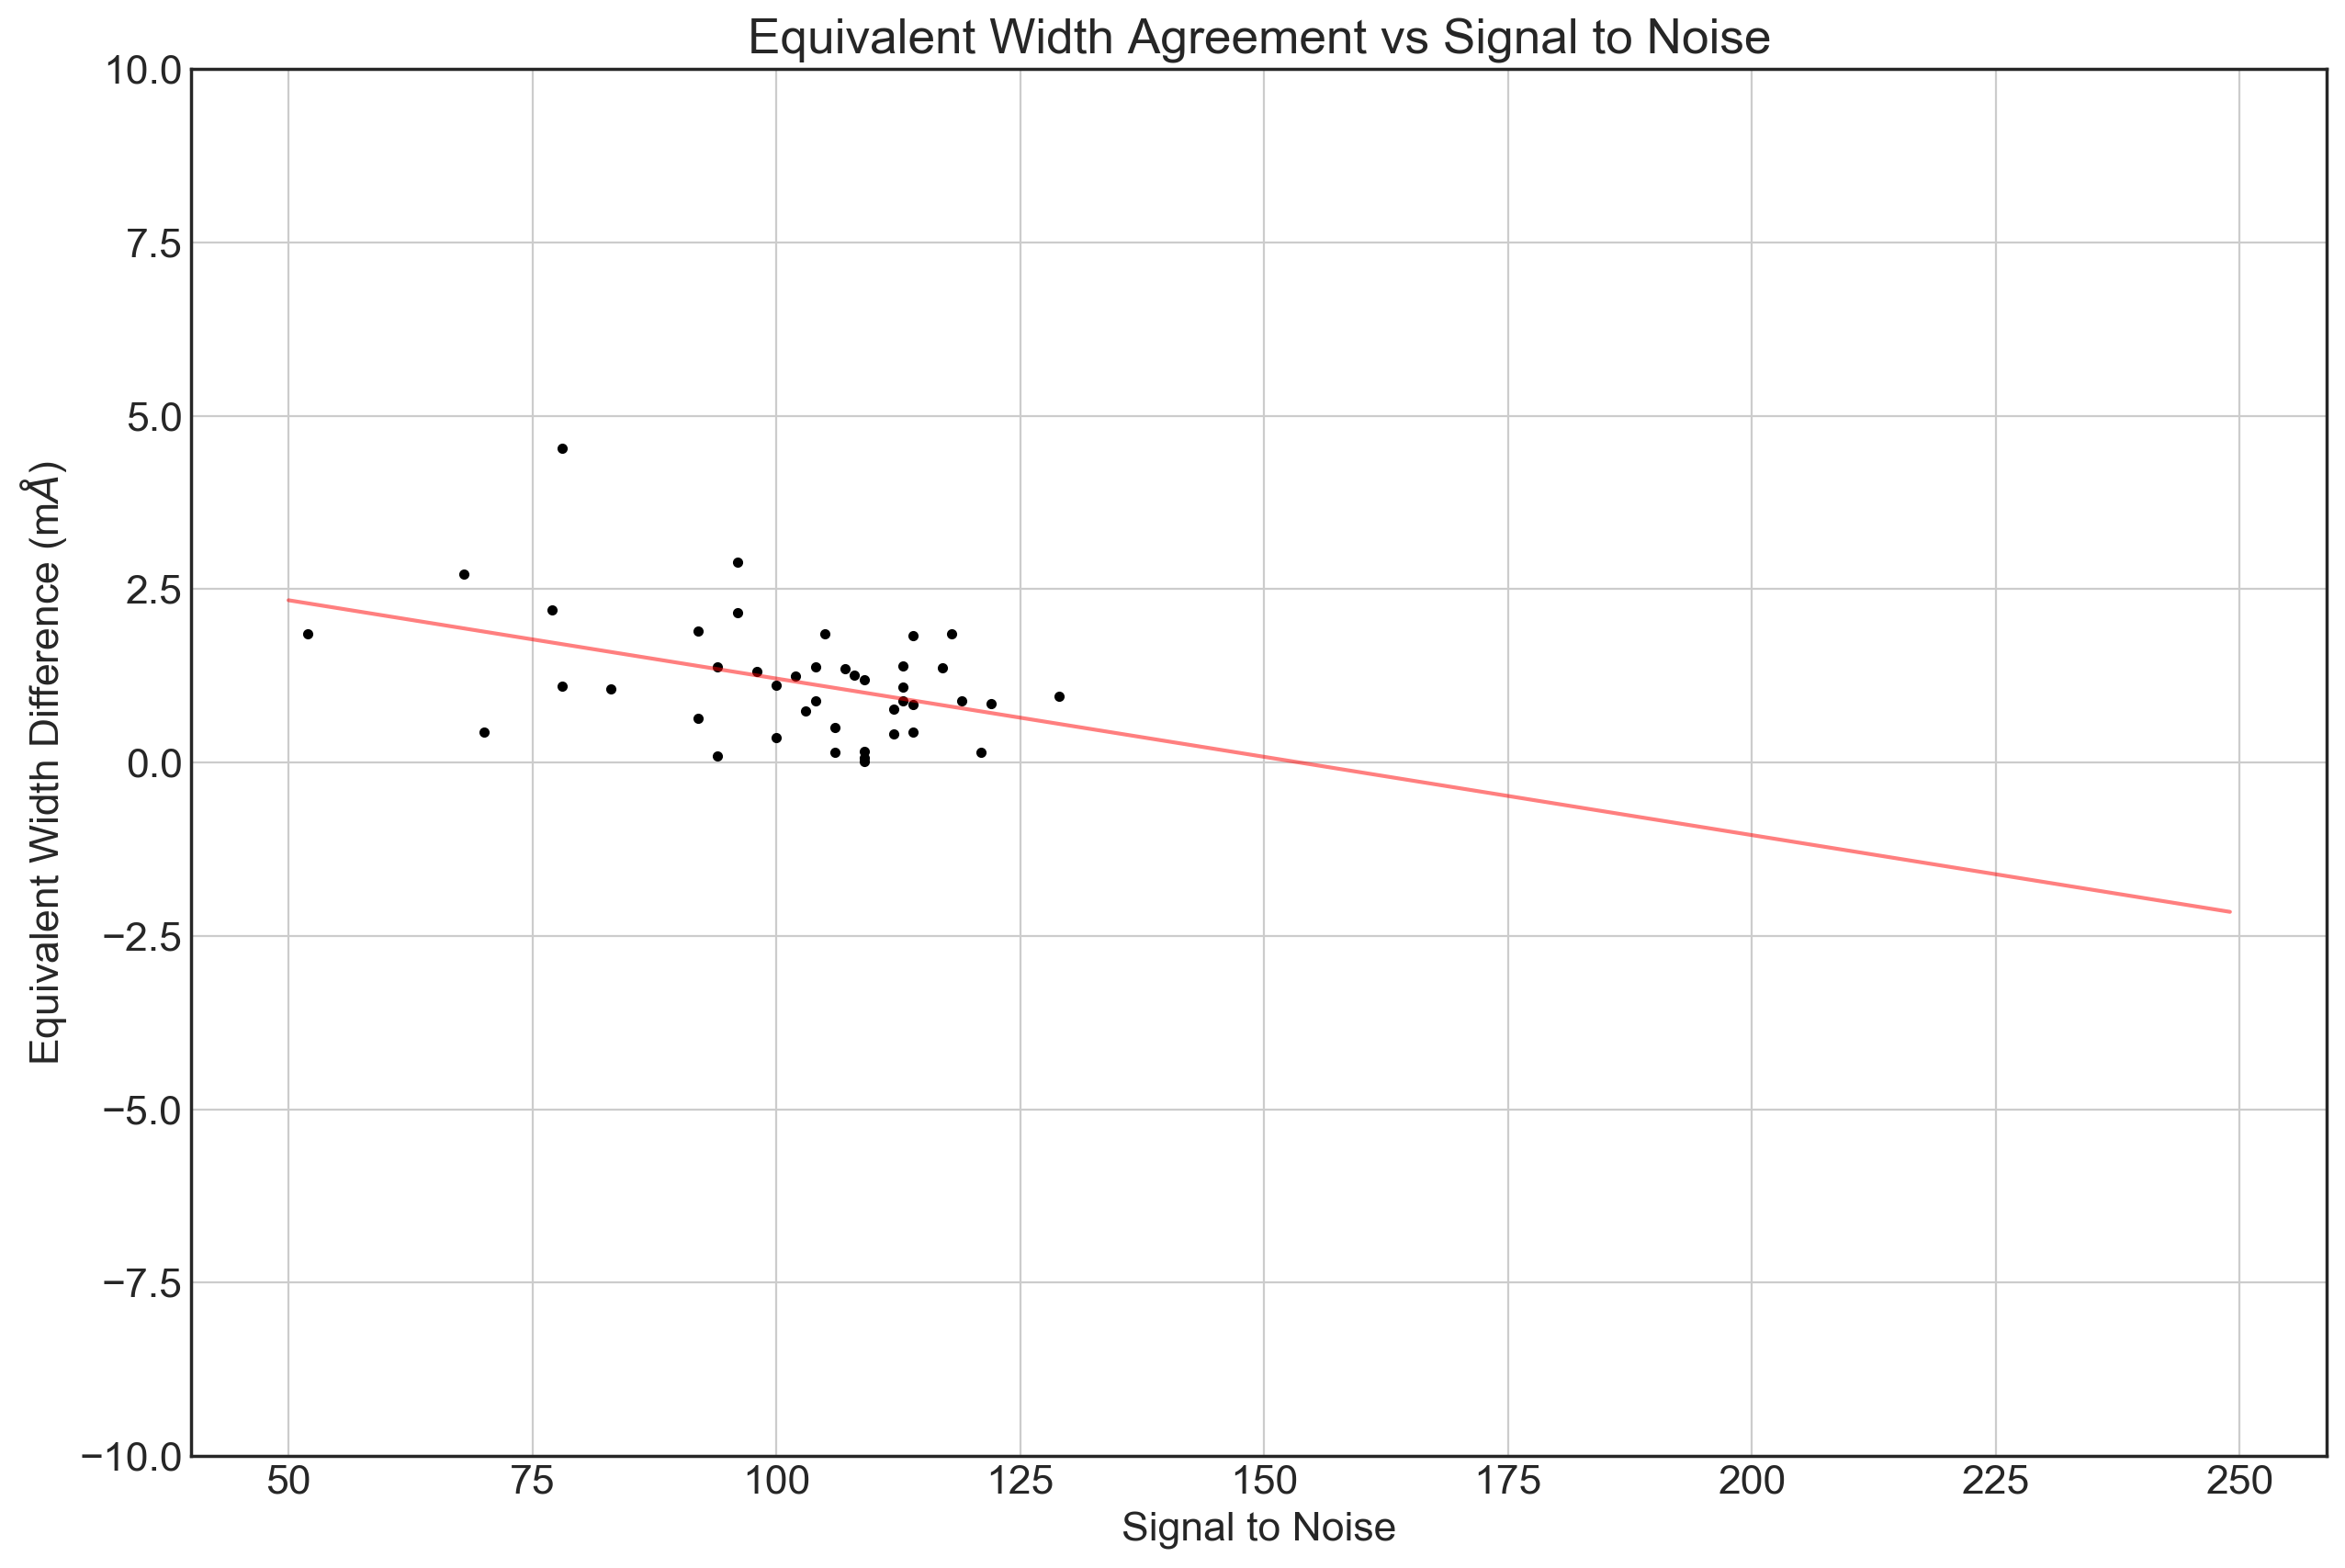

In [3]:
tame_outputs = glob.glob('data/ew_known/equiv_widths/*.ew')
byhand_outputs = ['data/ew_known/tame_inputs/'+output.split('/')[-1] for output in tame_outputs]
output_labels = [output.split('/')[-1].split('.')[0] for output in tame_outputs]


fig = plt.figure(figsize=(15,10))
fig.dpi = 200
plt.grid()
plt.xlabel(r"Signal to Noise")
plt.ylabel("Equivalent Width Difference (m$\AA$)")
plt.title("Equivalent Width Agreement vs Signal to Noise")
plt.ylim(-10,10)

pdiff_avg = []
snr_list = []
for byhand_output, tame_output,label in zip(byhand_outputs, tame_outputs,output_labels):

    ew_hand = pd.read_csv(byhand_output,delim_whitespace=True,header = None)
    ew_tame = pd.read_csv(tame_output,skiprows=1,delim_whitespace=True,header=None)
    hand_df = ew_hand[[0,4]].sort_values(by=0, ascending=False) # Wavelength and Equivalent Width
    tame_df = ew_tame # Wavelength, Equivalent Width, and linecenter
    label_items = label.split("_")
    cluster, star = label_items[0:2]
    star = star[0:-3]
    
    df = snr_dict[cluster]
    idx = df.index[df['Star'] == int(star)].tolist()
    snr = float(df.loc[idx]['S/N'])
    pdiff = np.array(tame_df[1]) - np.array(hand_df[4])
    
       
    masked_pdiff = [val for val in pdiff if not np.isinf(val) and not (np.isnan(val))]
    pdiff_avg.append(abs(np.mean(masked_pdiff)))
    snr_list.append(snr)

#Attempt a linear fit
coeffs = np.polyfit(snr_list, pdiff_avg, 1)
print(list(coeffs))
p = np.poly1d(coeffs)

yhat = p(snr_list)
ybar = np.sum(pdiff_avg)/len(pdiff_avg)
ssreg = np.sum((yhat-ybar)**2)
sstot = np.sum((pdiff_avg - ybar)**2)
print("R-Squared: ",ssreg / sstot)

x = np.arange(50,250,1)
y = coeffs[0]*x + coeffs[1]
plt.plot(snr_list, pdiff_avg, '.', color='k', label=label)
plt.plot(x, y, '-', color='r', label=label, alpha = 0.5)

### Lowercut
For lowercut, the optimal values have been chosen per line from all of the observations with known EWs. However, signal-to-noise changes from observation to observation, so if the lowercut value correlates with snr this might introduce noise into the chosen lowercut value. In an attempt to characterize this, we'll look through all of the observations and compare the typical lowercut value chosen with the signal-to-noise of the observation.

[6.1536650538089924e-05, 0.97799851869964449]
R-Squared:  0.124567333148


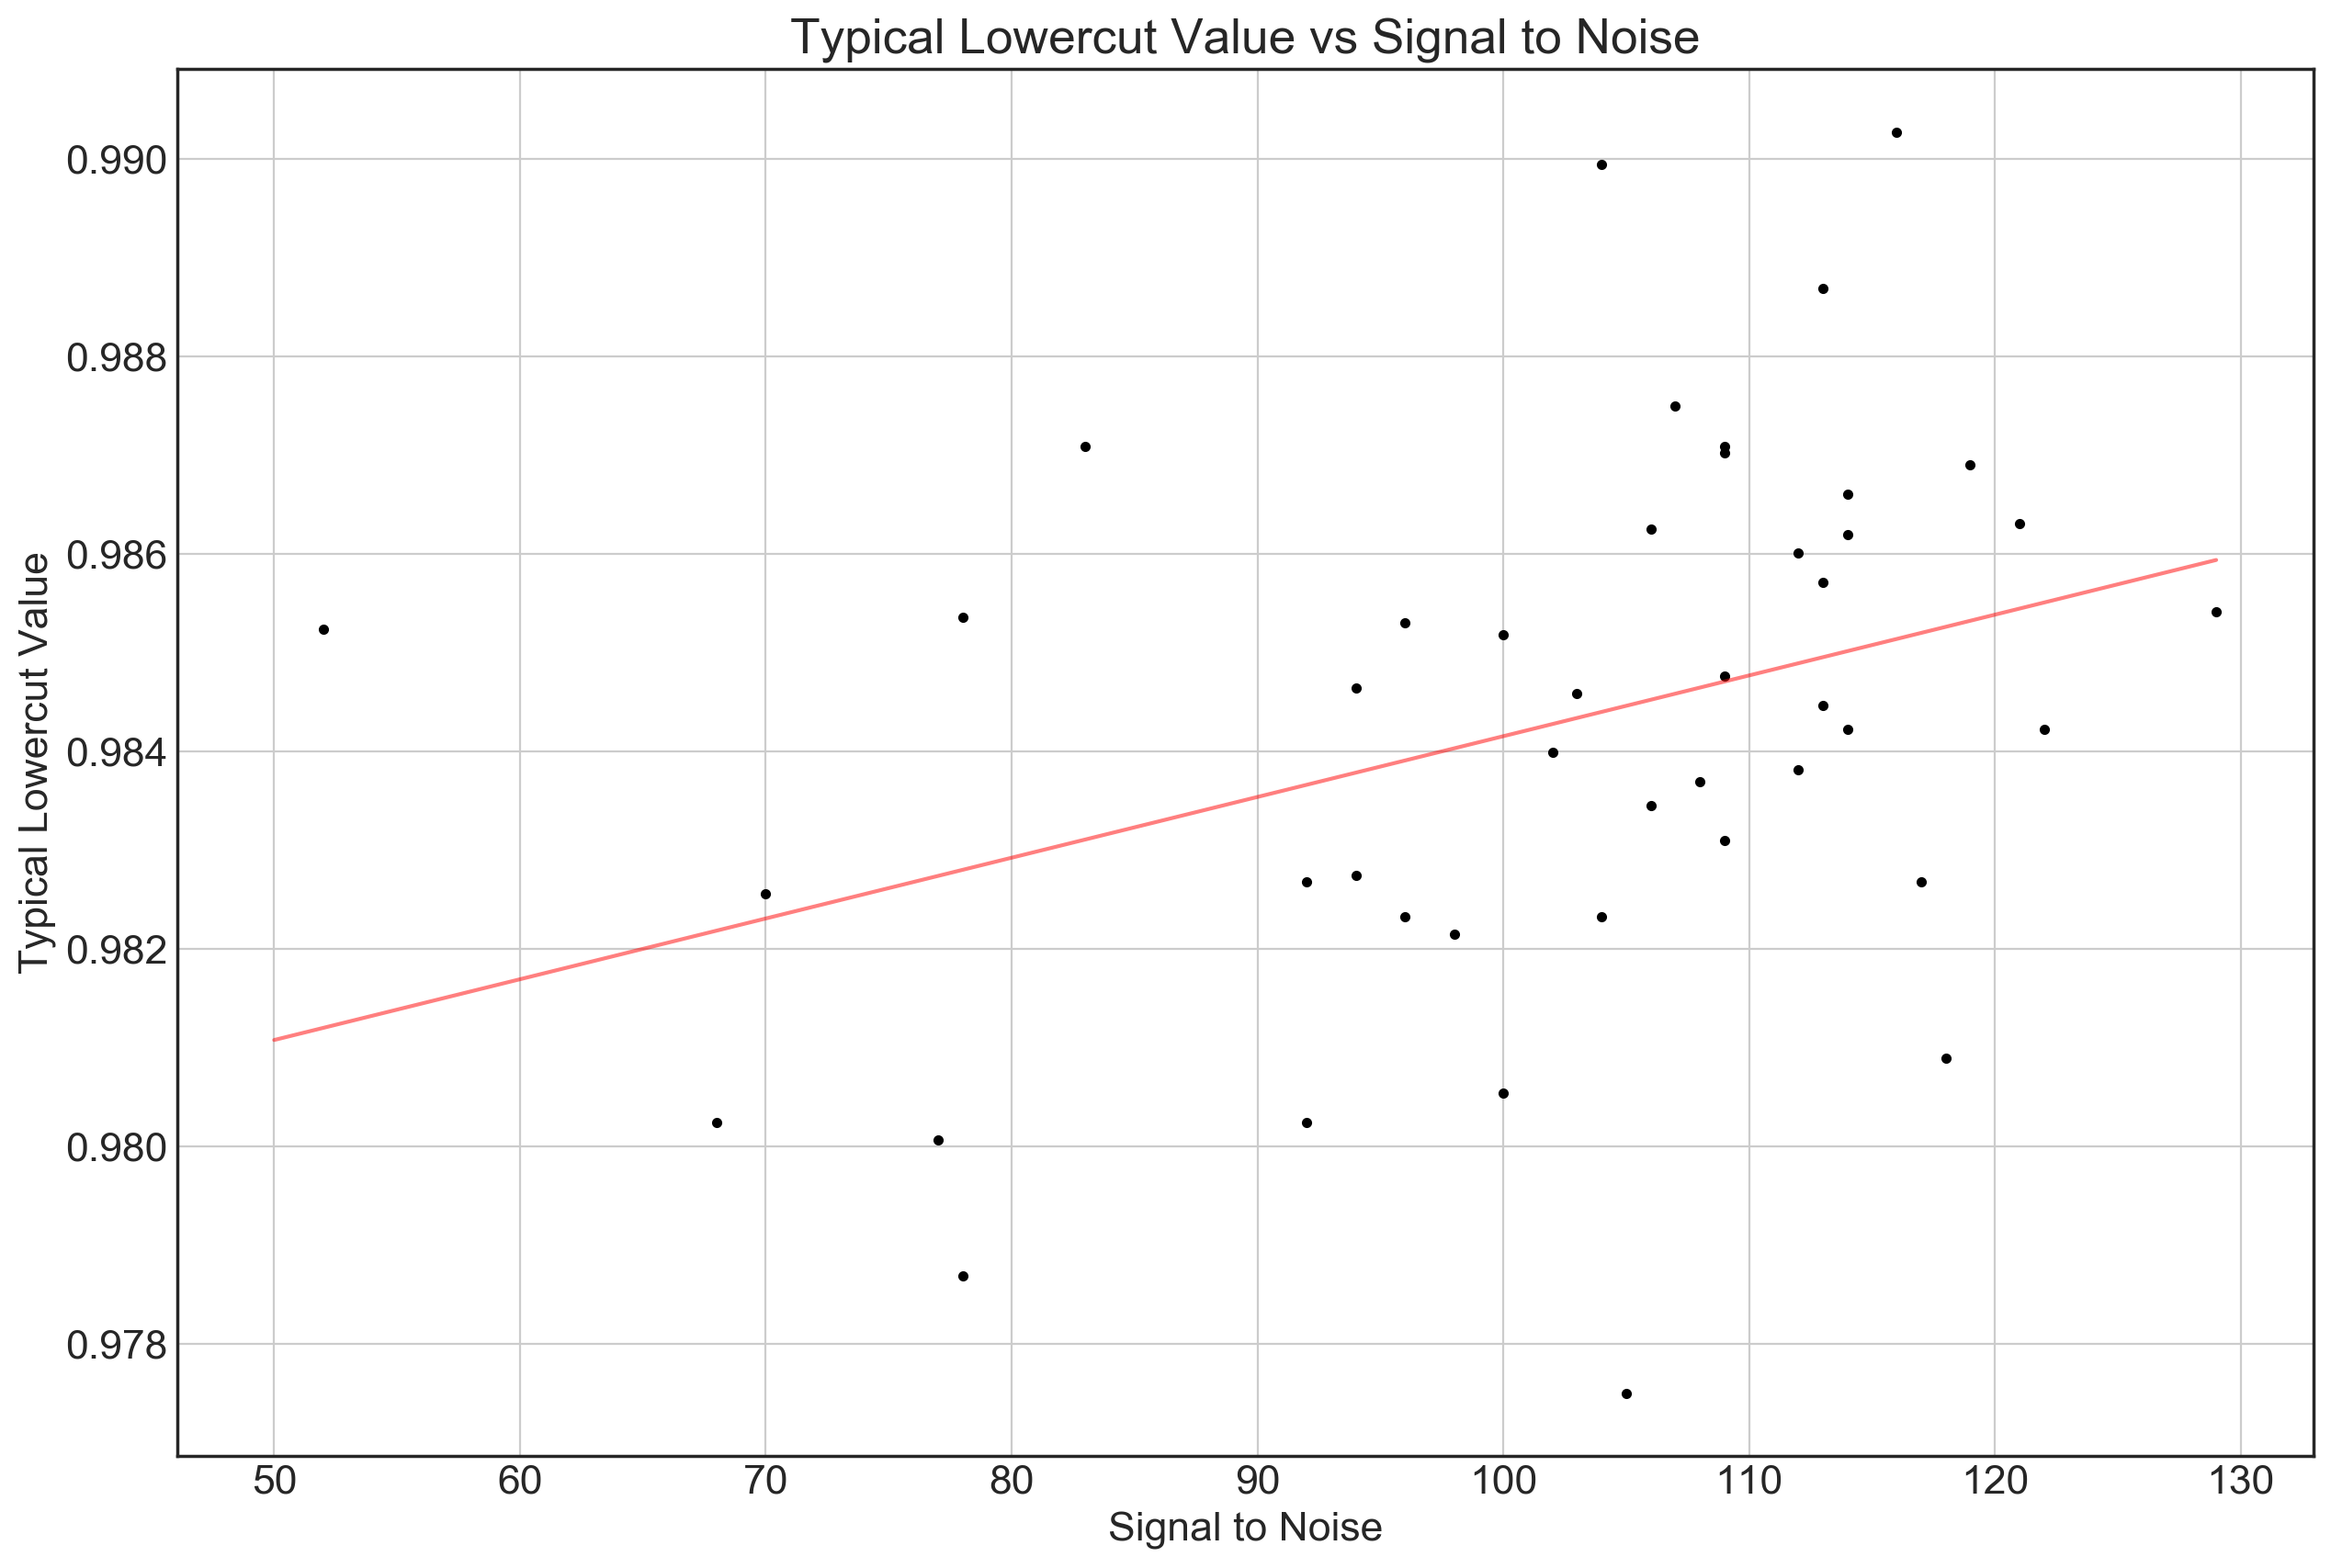

In [4]:
tame_outputs = glob.glob('data/ew_known/tame_outputs/*.json')
byhand_outputs = ['data/ew_known/tame_inputs/'+output.split('/')[-1].split(".")[0] + ".ew" for output in tame_outputs]
output_labels = [output.split('/')[-1].split('.')[0] for output in tame_outputs]


obs_snr = []
obs_lc = []
for byhand_output, tame_output in zip(byhand_outputs,tame_outputs):
    
    # Get S/N
    label_items = tame_output.split("/")[-1].split("_")
    cluster, star = label_items[0:2]
    star = star[0:-3]
    df = snr_dict[cluster]
    idx = df.index[df['Star'] == int(star)].tolist()
    snr = float(df.loc[idx]['S/N'])
    obs_snr.append(snr)
    
    # Get by-hand measurement dataframe
    ew_hand = pd.read_csv(byhand_output,delim_whitespace=True,header = None)
    hand_df = ew_hand[[0,4]].sort_values(by=0, ascending=False) # Wavelength and Equivalent Width
    
    
    # Read in json file of tame measurements
    with open(tame_output) as t:
        tame_data = json.load(t)
        
    line_lc = []    
    for line in tame_data.keys():
        idx = hand_df.index[hand_df[0] == float(line)].tolist()
        byhand_ew = float(hand_df.loc[idx][4])
        
        line_data = tame_data[line]
        lc = [run[0] for run in line_data]
        ew = [run[1] for run in line_data]
        min_idx = np.argmin(abs(np.array(ew)-byhand_ew))
        #print(lc[min_idx], ew[min_idx], byhand_ew)
        line_lc.append(lc[min_idx])
        
    obs_lc.append(np.mean(line_lc))
    
#Attempt a linear fit
coeffs = np.polyfit(obs_snr, obs_lc, 1)
print(list(coeffs))
p = np.poly1d(coeffs)

yhat = p(obs_snr)
ybar = np.sum(obs_lc)/len(obs_lc)
ssreg = np.sum((yhat-ybar)**2)
sstot = np.sum((obs_lc - ybar)**2)
print("R-Squared: ",ssreg / sstot)

x = np.arange(50,130,1)
y = coeffs[0]*x + coeffs[1]
    
fig = plt.figure(figsize=(15,10))
fig.dpi = 200
plt.grid()
plt.xlabel(r"Signal to Noise")
plt.ylabel("Typical Lowercut Value")
plt.title("Typical Lowercut Value vs Signal to Noise")

plt.plot(obs_snr, obs_lc, '.', color = 'k')
plt.plot(x, y, '-', color='r', label=label, alpha = 0.5)

## How does SNR Affect the Precise Lowercut Method?

In [5]:
# Select Datasets and extract equivalent widths
outputs = glob.glob("tame-1.1.0/*sm1.json")
by_hand = glob.glob("tame-1.1.0/*.ew")
lc_range = np.arange(0.95,0.995,0.0001)
len_range = 10


d = {'JSON File': outputs, 'By-Hand File': by_hand}
disp_df = pd.DataFrame(data=d)

In [157]:
# Find optimal lowercut value
write_out = False
plot = True

with open(outputs[0]) as jsonfile:
    jsondata = json.load(jsonfile)
    key = list(jsondata.keys())[2]
    lowcuts = [cut for cut,ew in jsondata[key]]
    line_list = list(jsondata.keys())
    line_list = np.array(sorted(np.array(line_list).astype(float))).astype(str)

if write_out:
    f_out = open("as.txt","w")
solns_dev = []
closest_dev = []
closest_pdiffs = []

line_dict = {}
n=30
for line in line_list[n:n+1]:
    print(line)
    pdiff_all = []
    lowercut_all = []
    snr_all = []
    #pdiff_iso = []
    #snr_iso = []
    for i in range(len(outputs)):
        if 'ngc2204_3321red' in outputs[i]:
            pass
        clust, star = outputs[i].split("/")[-1].split("_")[0:2]
        star = star[0:-3]
        #print(clust, star)
        idx = snr_dict[clust].index[snr_dict[clust]['Star'] == int(star)].tolist()
        snr = float(snr_dict[clust].loc[idx]['S/N'])
        #print(snr)

        with open(outputs[i]) as jsonfile, open(by_hand[i]) as ewfile:
            
            jsondata = json.load(jsonfile)
            handdata = pd.read_csv(ewfile, delim_whitespace = True, header = None)[[0,4]]
            hand_dict = dict(zip([str(i) for i in handdata[0].tolist()], handdata[4].tolist()))
            key = line
            lowercut = [cut for cut,ew in jsondata[key]]
            ew_meas = [ew for cut,ew in jsondata[key]]
            #print(outputs[i])
            #print(ew_meas)
            #print(hand_dict[key])
            
            label = disp_df['JSON File'][i].split('/')[-1].split('.')[0]
            if hand_dict[key] == 0:
                continue
            if len(lowercut) < len_range:
                continue
            
            ew_pdiff = ((np.array(ew_meas)-hand_dict[key])/hand_dict[key]) * 100
            ew_absdiff = np.array(ew_meas) - hand_dict[key]
            #plt.plot(lowercut,ew_pdiff,'.',color='k')
            #print(pdiff_all, list(ew_absdiff))
            #print(hand_dict[key])
            pdiff_all = pdiff_all+list(ew_absdiff)
            lowercut_all = lowercut_all + lowercut
            snr_all = snr_all + [snr]*len(ew_absdiff)
            #pdiff_iso = pdiff_iso + [ew_absdiff[8]]
            #snr_iso = snr_iso + [snr]
            
    trace1 = go.Scatter3d(x=pdiff_all,y=lowercut_all,z=snr_all,
                          mode='markers',opacity=0.5) 

    
    data = [trace1]
    layout = go.Layout(scene = dict(xaxis = dict(title='Equivalent Width Diff (mA)', range = [-30,30]),yaxis = dict(title='Lowercut'),zaxis = dict(title='SNR'),),width=700,margin=dict(r=20, b=10, l=10, t=10))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename = 'snr_lowercut')
    

5793.91


### Isolate One Lowercut Value

[0.39999999999999858, 1.7000000000000028, 0.59999999999999432, 2.7999999999999972, 1.2999999999999972, 3.5, -3.8999999999999986, -4.4000000000000057, -6.1999999999999957, 3.0999999999999943, -2.1999999999999957, 0.099999999999994316, -1.2999999999999972, -2.1000000000000014, -0.79999999999999716, 1.3000000000000043, 1.1000000000000014, -7.6000000000000014, 5.1000000000000014, -3.7000000000000028, -0.80000000000000426, 6.0, -0.90000000000000568, 0.19999999999999574, 2.6000000000000014, 4.5, 2.5, 1.1999999999999957, 4.5, -9.9000000000000057, -12.950000000000003, -9.5, -12.0, -3.7000000000000028, -12.400000000000006, -2.2999999999999972, -5.4000000000000057, -8.7000000000000028, -5.7999999999999972]
[-0.075455512157215535, 5.9022211543049492]
R-Squared:  0.0626281871336


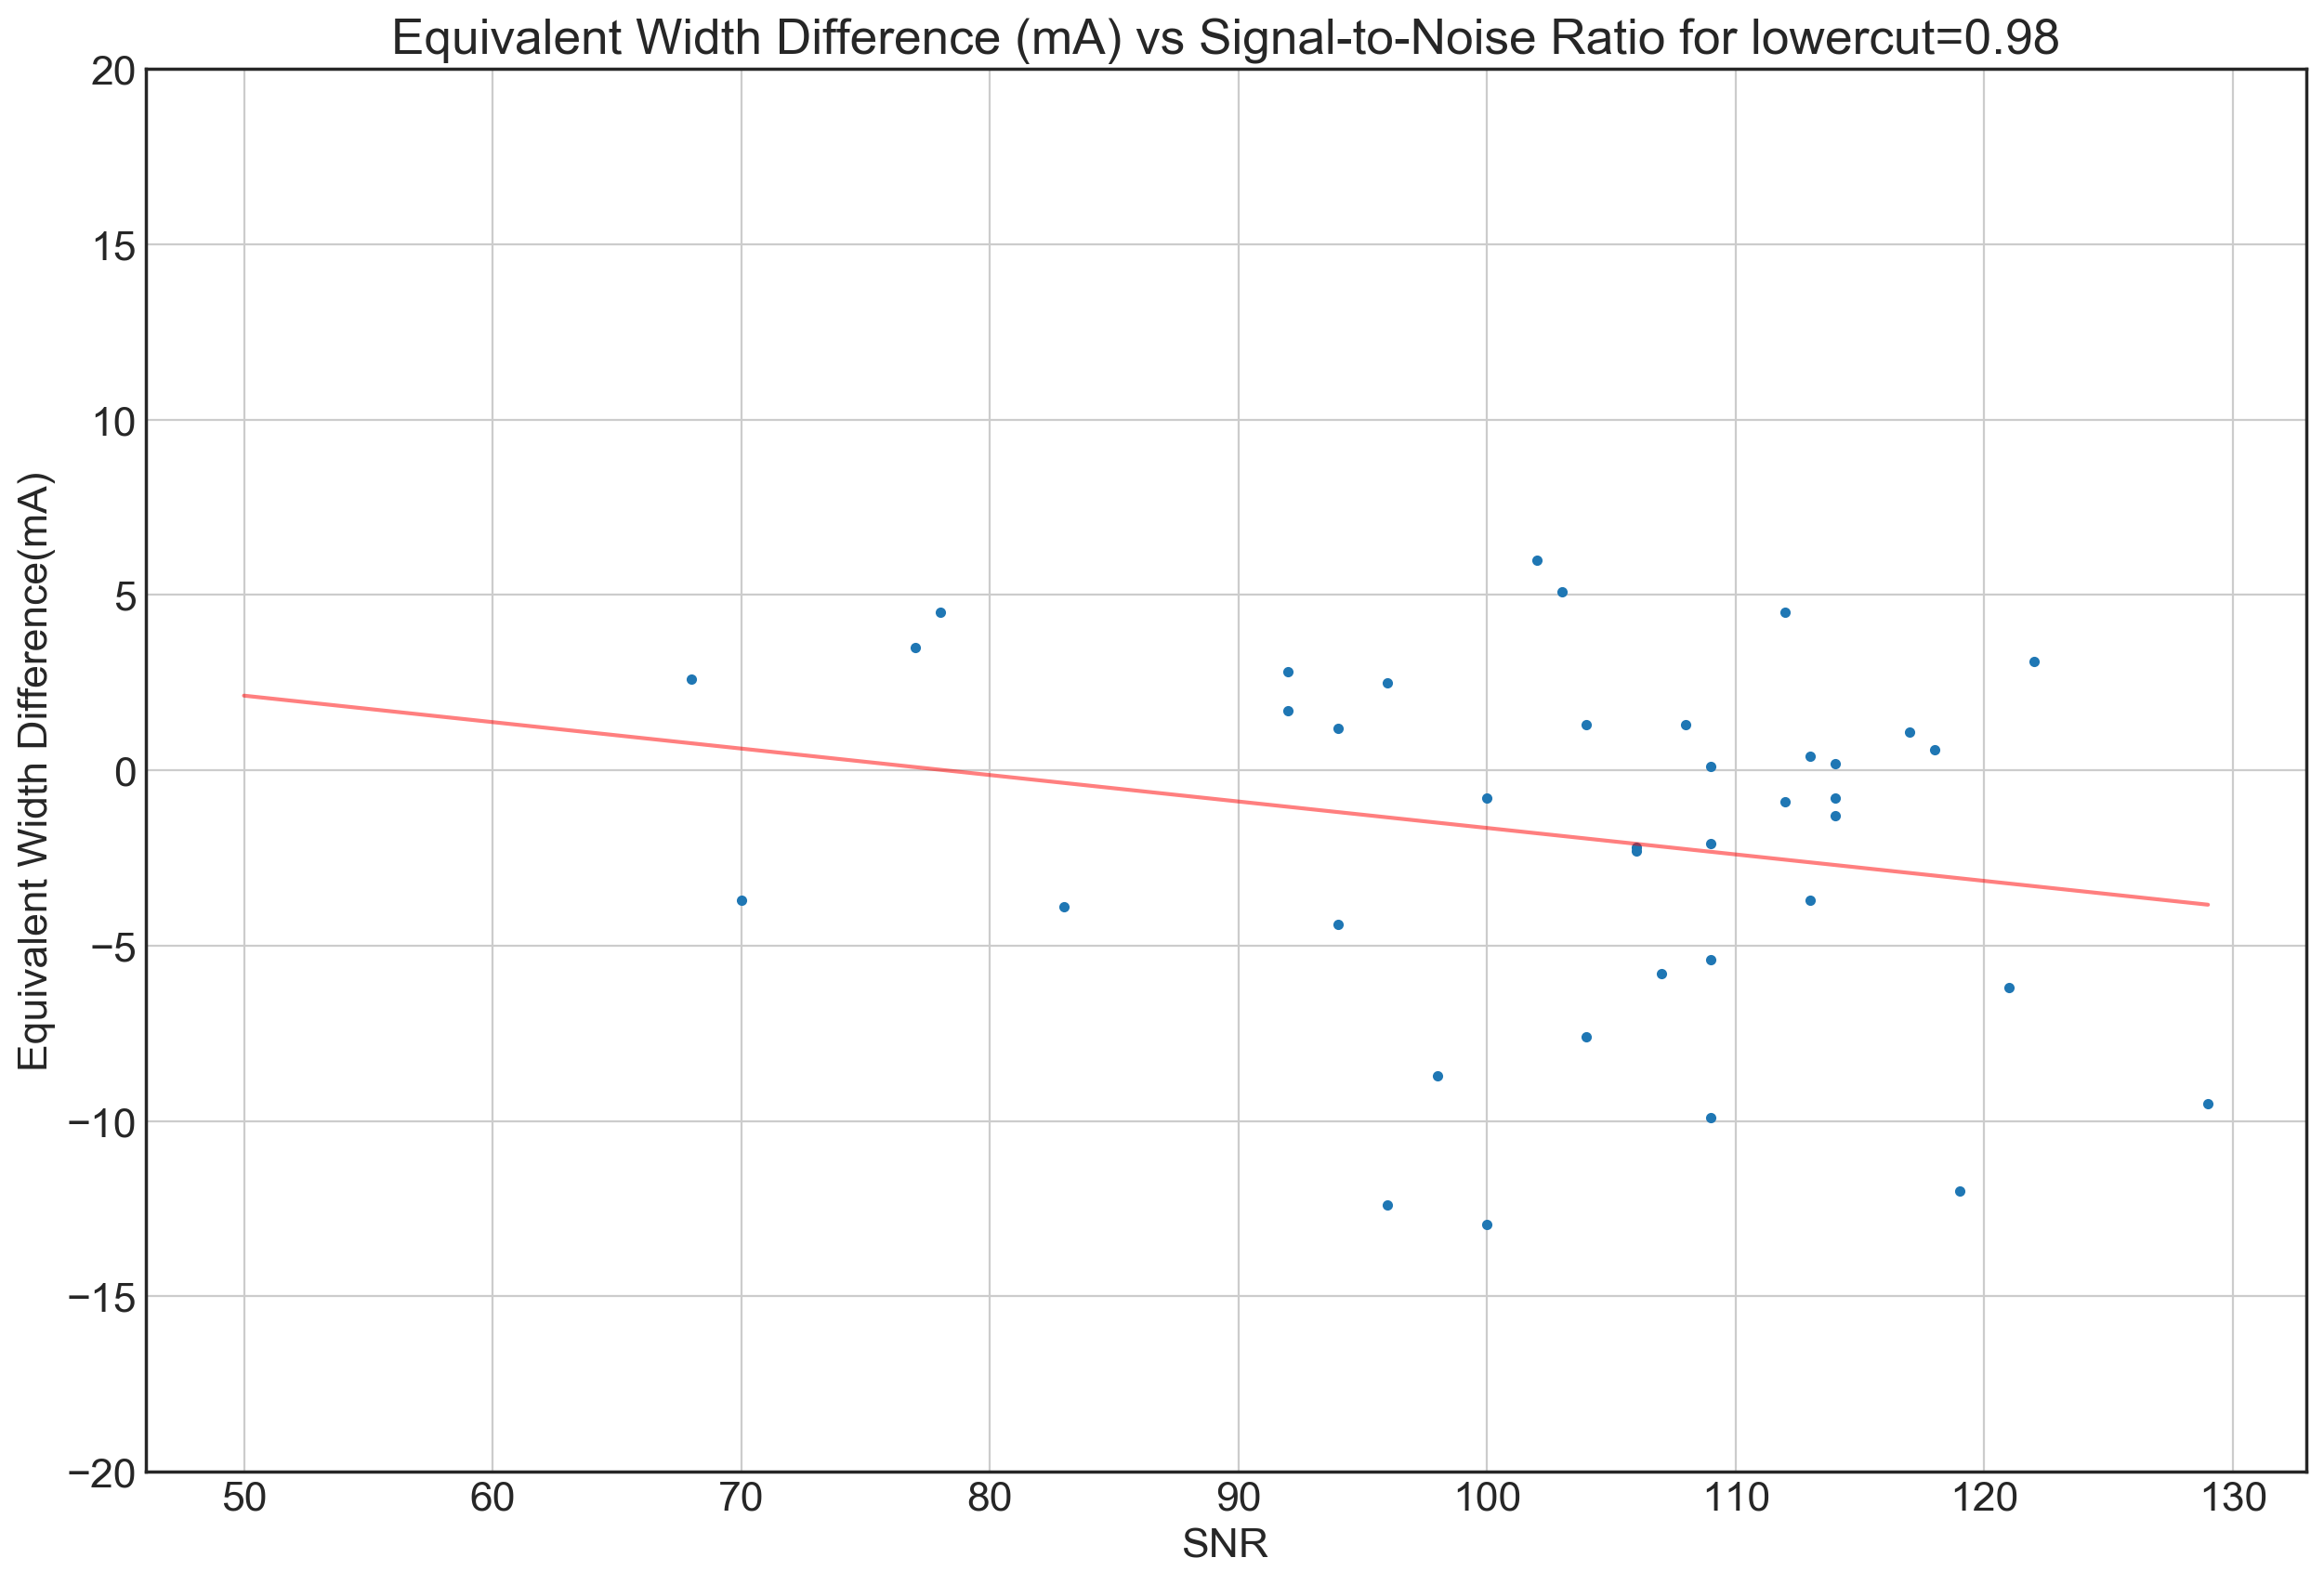

In [158]:
lc = 0.98
mask = np.array(lowercut_all) == lc

snr_iso = np.array(snr_all)[mask]
pdiff_iso = np.array(pdiff_all)[mask]


zipped_data = list(zip(snr_iso,pdiff_iso))
data = np.ma.compress_rows(sigma_clip(zipped_data,sigma=3, axis = 0))
#print(np.ma.compress_rows(data))
snr_iso_clip = [tup[0] for tup in data]
pdiff_iso_clip = [tup[1] for tup in data]
print(pdiff_iso_clip)


#Attempt a linear fit
coeffs = np.polyfit(snr_iso_clip, pdiff_iso_clip, 1)
print(list(coeffs))
p = np.poly1d(coeffs)

yhat = p(snr_iso)
ybar = np.sum(pdiff_iso_clip)/len(pdiff_iso_clip)
ssreg = np.sum((yhat-ybar)**2)
sstot = np.sum((pdiff_iso_clip - ybar)**2)
print("R-Squared: ",ssreg / sstot)

x = np.arange(50,130,1)
y = coeffs[0]*x + coeffs[1]


fig = plt.figure(figsize=(15,10),dpi = 200)
plt.title("Equivalent Width Difference (mA) vs Signal-to-Noise Ratio for lowercut={}".format(lc))
plt.xlabel("SNR")
plt.ylabel("Equivalent Width Difference(mA)")
plt.ylim(-20,20)
plt.grid()
plt.plot(snr_iso_clip, pdiff_iso_clip, '.')
plt.plot(x, y, '-', color='r', label=label, alpha = 0.5)

## Collapse Across Lowercut

[0.39999999999999858, 1.7000000000000028, 0.59999999999999432, 2.7999999999999972, 1.2999999999999972, 3.5, -3.8999999999999986, -4.4000000000000057, -6.1999999999999957, 3.0999999999999943, -2.1999999999999957, 0.099999999999994316, -1.2999999999999972, -2.1000000000000014, -0.79999999999999716, 1.3000000000000043, 1.1000000000000014, -7.6000000000000014, 5.1000000000000014, -3.7000000000000028, -0.80000000000000426, 6.0, -0.90000000000000568, 0.19999999999999574, 2.6000000000000014, 4.5, 2.5, 1.1999999999999957, 4.5, -9.9000000000000057, -12.950000000000003, -9.5, -12.0, -3.7000000000000028, -12.400000000000006, -2.2999999999999972, -5.4000000000000057, -8.7000000000000028, -5.7999999999999972]
[-0.069684294377310288, 5.6662569346926732]
R-Squared:  0.0857368510094


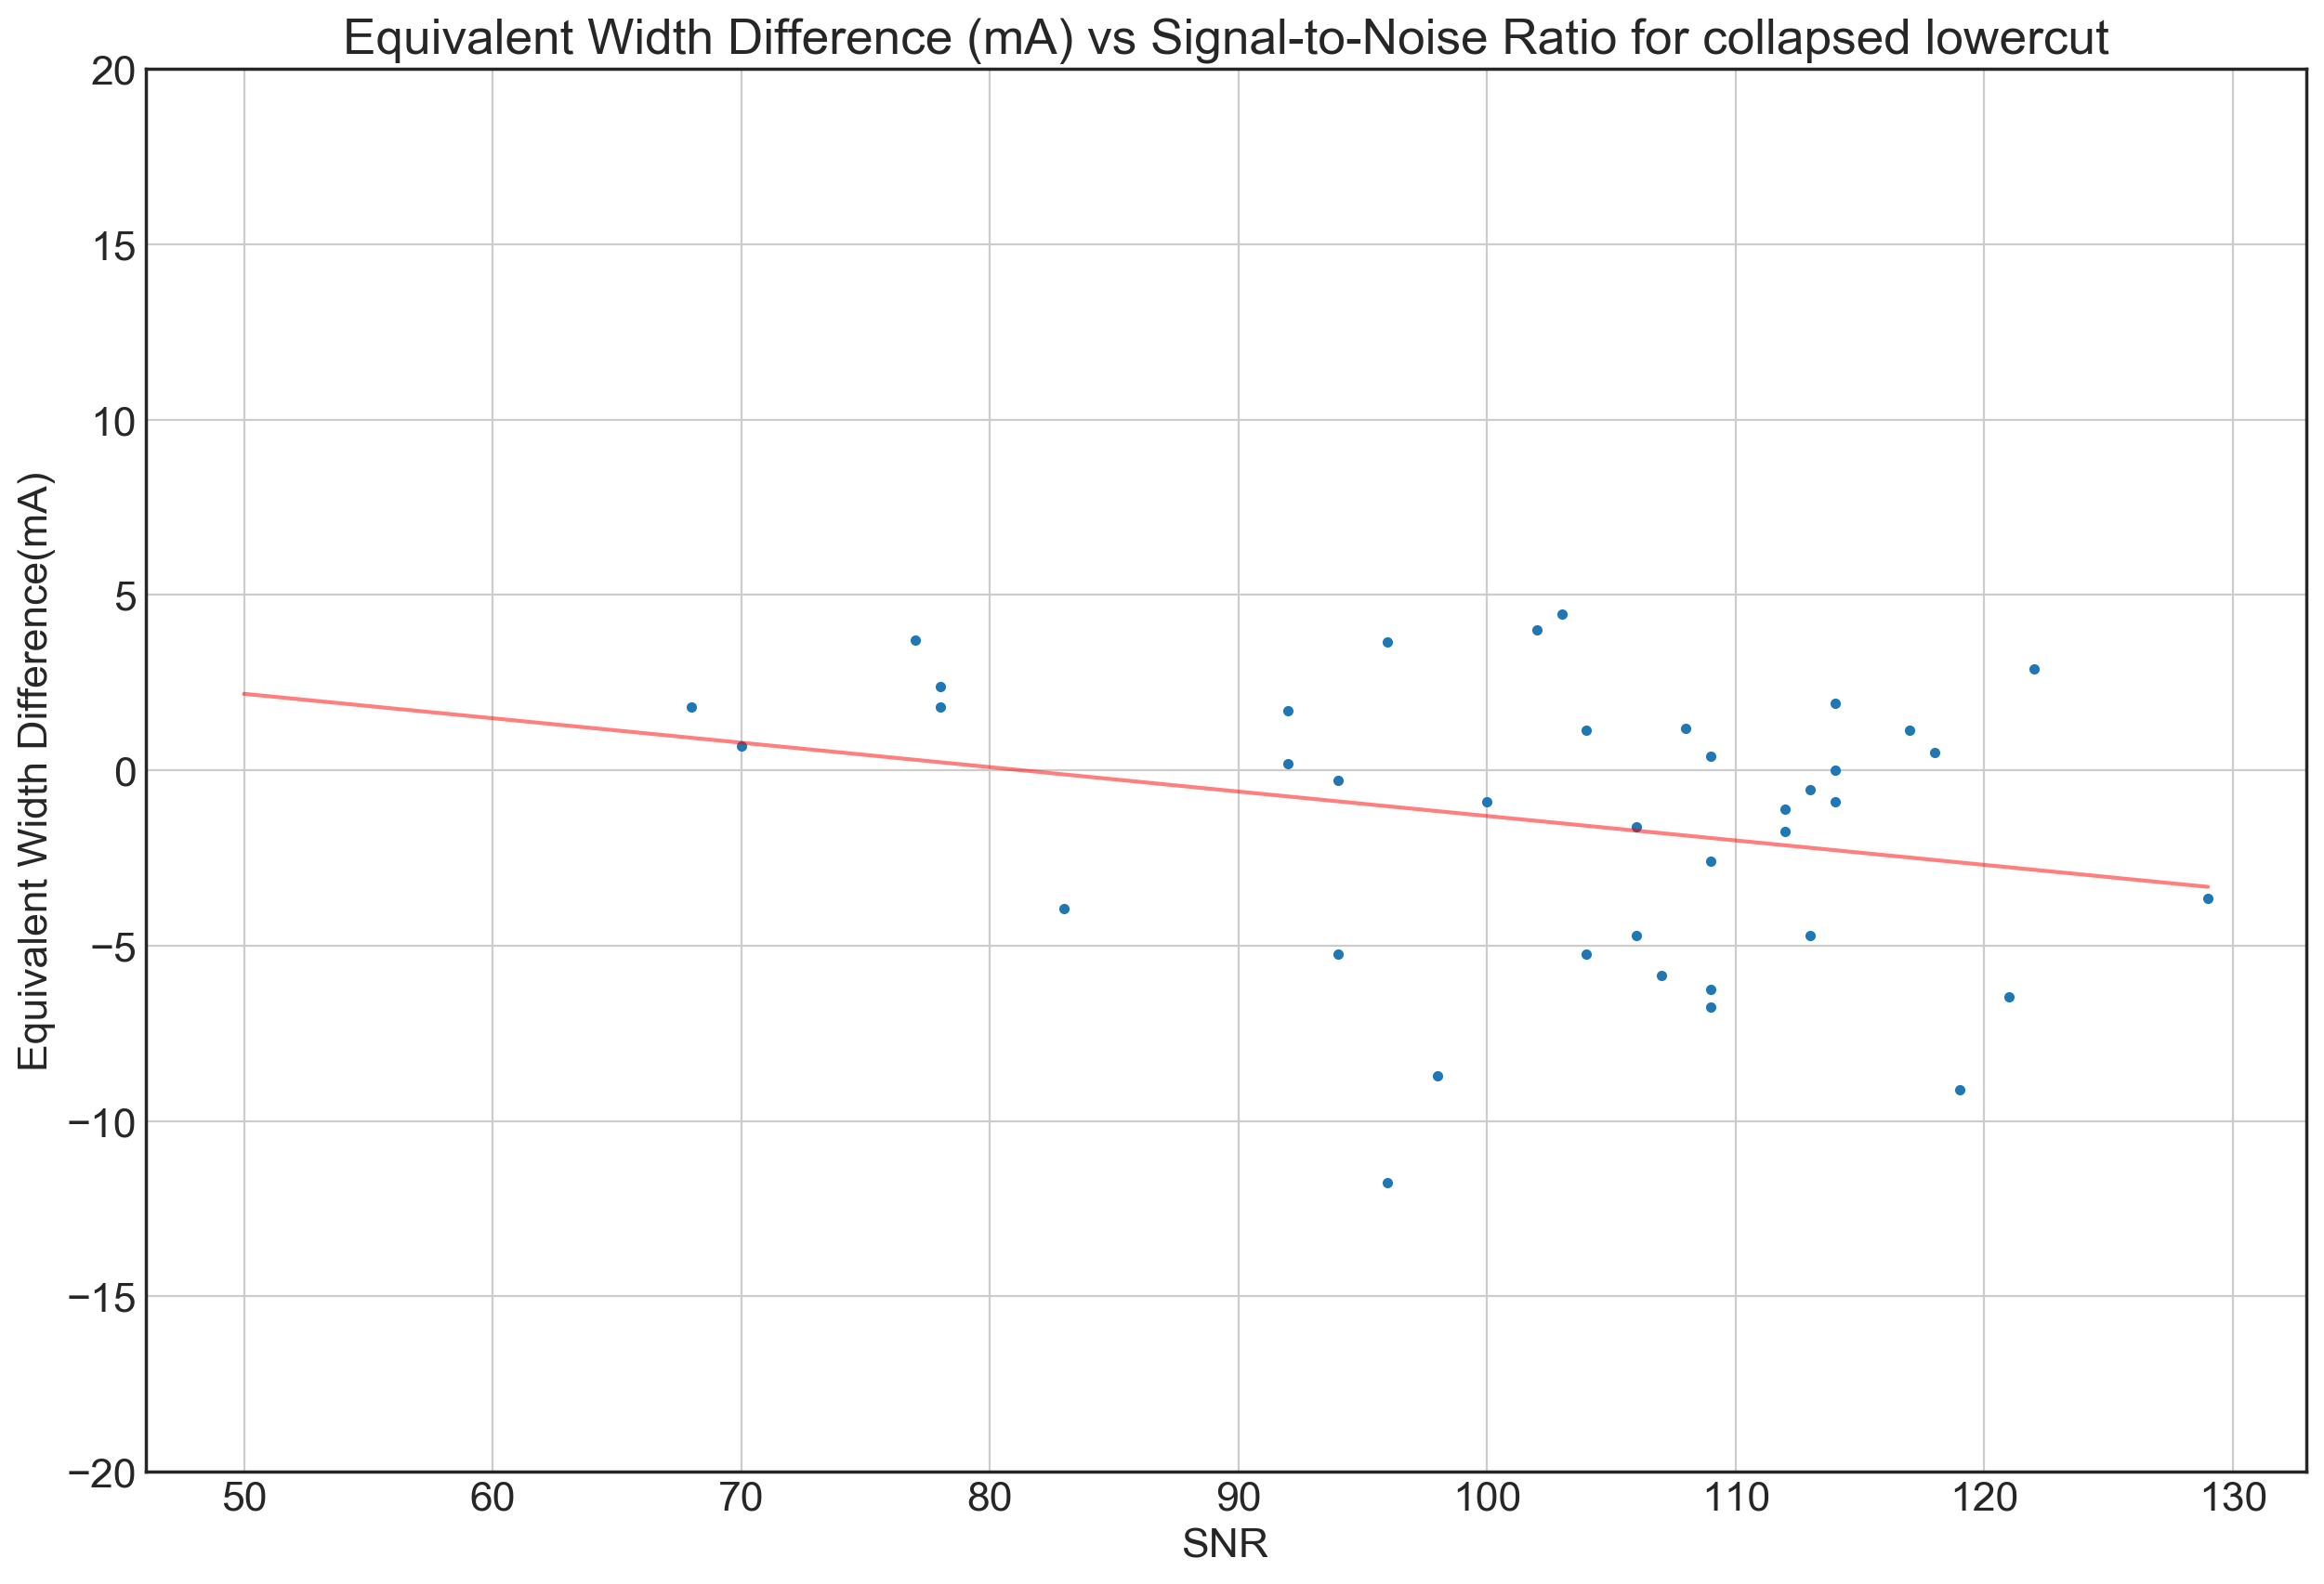

In [161]:
count = 0
collapsed_pdiff = []
collapsed_snr = []
while count < len(pdiff_all):
    collapsed_pdiff.append(np.median(sorted(pdiff_all[count:count+len_range])))
    collapsed_snr.append(np.median(snr_all[count:count+len_range]))
    count += len_range
    
zipped_data = list(zip(collapsed_snr,collapsed_pdiff))
data = np.ma.compress_rows(sigma_clip(zipped_data,sigma=3, axis = 0))
#print(np.ma.compress_rows(data))
collapsed_snr = [tup[0] for tup in data]
collapsed_pdiff = [tup[1] for tup in data]
print(pdiff_iso_clip)

#Attempt a linear fit
coeffs = np.polyfit(collapsed_snr, collapsed_pdiff, 1)
print(list(coeffs))
p = np.poly1d(coeffs)

yhat = p(snr_iso)
ybar = np.sum(collapsed_pdiff)/len(collapsed_pdiff)
ssreg = np.sum((yhat-ybar)**2)
sstot = np.sum((collapsed_pdiff - ybar)**2)
print("R-Squared: ",ssreg / sstot)

x = np.arange(50,130,1)
y = coeffs[0]*x + coeffs[1]


fig = plt.figure(figsize=(15,10),dpi = 200)
plt.title("Equivalent Width Difference (mA) vs Signal-to-Noise Ratio for collapsed lowercut")
plt.xlabel("SNR")
plt.ylabel("Equivalent Width Difference(mA)")
plt.ylim(-20,20)
plt.grid()
plt.plot(collapsed_snr, collapsed_pdiff, '.')
plt.plot(x, y, '-', color='r', label=label, alpha = 0.5)

## Sample Fit Statistics

In [165]:
# Find optimal lowercut value
write_out = False
plot = True

with open(outputs[0]) as jsonfile:
    jsondata = json.load(jsonfile)
    key = list(jsondata.keys())[2]
    lowcuts = [cut for cut,ew in jsondata[key]]
    line_list = list(jsondata.keys())
    line_list = np.array(sorted(np.array(line_list).astype(float))).astype(str)

if write_out:
    f_out = open("as.txt","w")
fit_m = []
fit_b = []
fit_rsqrd = []
line_dict = {}
n=30
for line in line_list:
    print(line)
    pdiff_all = []
    lowercut_all = []
    snr_all = []

    for i in range(len(outputs)):
        if 'ngc2204_3321red' in outputs[i]:
            pass
        clust, star = outputs[i].split("/")[-1].split("_")[0:2]
        star = star[0:-3]
        #print(clust, star)
        idx = snr_dict[clust].index[snr_dict[clust]['Star'] == int(star)].tolist()
        snr = float(snr_dict[clust].loc[idx]['S/N'])
        #print(snr)

        with open(outputs[i]) as jsonfile, open(by_hand[i]) as ewfile:
            
            jsondata = json.load(jsonfile)
            handdata = pd.read_csv(ewfile, delim_whitespace = True, header = None)[[0,4]]
            hand_dict = dict(zip([str(i) for i in handdata[0].tolist()], handdata[4].tolist()))
            key = line
            lowercut = [cut for cut,ew in jsondata[key]]
            ew_meas = [ew for cut,ew in jsondata[key]]
            #print(outputs[i])
            #print(ew_meas)
            #print(hand_dict[key])
            
            label = disp_df['JSON File'][i].split('/')[-1].split('.')[0]
            if hand_dict[key] == 0:
                continue
            if len(lowercut) < len_range:
                continue
            
            ew_pdiff = ((np.array(ew_meas)-hand_dict[key])/hand_dict[key]) * 100
            ew_absdiff = np.array(ew_meas) - hand_dict[key]
            #plt.plot(lowercut,ew_pdiff,'.',color='k')
            #print(pdiff_all, list(ew_absdiff))
            #print(hand_dict[key])
            pdiff_all = pdiff_all+list(ew_absdiff)
            lowercut_all = lowercut_all + lowercut
            snr_all = snr_all + [snr]*len(ew_absdiff)
            #pdiff_iso = pdiff_iso + [ew_absdiff[8]]
            #snr_iso = snr_iso + [snr]
            
    count = 0
    collapsed_pdiff = []
    collapsed_snr = []
    while count < len(pdiff_all):
        collapsed_pdiff.append(np.median(sorted(pdiff_all[count:count+len_range])))
        collapsed_snr.append(np.median(snr_all[count:count+len_range]))
        count += len_range
    
    zipped_data = list(zip(collapsed_snr,collapsed_pdiff))
    data = np.ma.compress_rows(sigma_clip(zipped_data,sigma=3, axis = 0))
    #print(np.ma.compress_rows(data))
    collapsed_snr = [tup[0] for tup in data]
    collapsed_pdiff = [tup[1] for tup in data]

    #Attempt a linear fit
    coeffs = np.polyfit(collapsed_snr, collapsed_pdiff, 1)
    #print(list(coeffs))
    p = np.poly1d(coeffs)

    yhat = p(snr_iso)
    ybar = np.sum(collapsed_pdiff)/len(collapsed_pdiff)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((collapsed_pdiff - ybar)**2)
    #print("R-Squared: ",ssreg / sstot)
    fit_rsqrd.append(ssreg/sstot)
    fit_m.append(coeffs[0])
    fit_b.append(coeffs[1])
    

5234.63
5284.1
5307.36
5322.04
5325.56


KeyError: '5325.56'

In [166]:
print(fit_rsqrd)

[0.1512392261371211, 0.091264246237849428, 0.044800318147341991, 0.0055075001585126486]
